## 6.1 합성곱 층을 통한 학습
* 합성곱 층을 통한 학습으로 이미지 데이터를 분류해 봅니다. 학습은 model.fit()을 통해 합니다. fit을 통해 학습을 할 때는 학습에 사용할 이미지, 정답값, 학습할 데이터 크기, 학습 횟수 등을 지정할 수 있습니다. 학습을 위해 OpenCV를 사용하여 이미지 데이터를 불러옵니다. 정답 값인 label 값은 LabelEncoder로 수치 형태로 변경합니다. 5차시에서 생성해 두었던 합성곱 신경망 모델을 불러와서 학습을 진행합니다. 그리고 학습세트와 검증 세트의 학습 결과를 비교해 봅니다. 학습 후 결과를 history 로 받아서 accuracy 와 loss를 비교합니다. accuracy는 정확도로 학습, 검정 세트를 통해 정답값의 비율을 확인할 수 있습니다. loss는 학습, 검증 세트를 통해 손실률입니다. EarlyStopping은 학습을 하다보면 어느 시점에서 모델의 성능이 정체하는 구간이 발생합니다. 성능 향상이 없으면 자동으로 훈련을 멈추게 됩니다. history 결과를 통해 에포크가 증가할 수록 학습데이터의 성능이 높아지고 손실이 줄어드는 것을 볼 수 있습니다. 하지만 검증 데이터는 어느 시점부터 성능향상이 정체되게 됩니다. 실습에서 사용한 에포크 수보다 더 큰 수로 증가시켜서 학습을 하게 되면 성능이 좋아지다가 어느시점에서 정체가 되는데 이 때  earlystopping을 통해 조기종료를 설정할 수 있습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tqdm as tqdm

In [2]:
import os
root_dir = "images/"
image_label = os.listdir(root_dir)
image_label.remove("test.csv")
image_label.remove("alien_test")
image_label

['cloudy', 'shine', 'sunrise', 'rainy', 'foggy']

In [3]:
import cv2
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [4]:
image_label

['cloudy', 'shine', 'sunrise', 'rainy', 'foggy']

In [5]:
for img_label in image_label:
    x,y = create_dataset(f"{root_dir}{img_label}", img_label)

100%|██████████| 300/300 [00:01<00:00, 192.14it/s]


In [6]:
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((1497, 150, 150, 3), (1497,))

In [7]:
# 'cloudy', 'shine', 'sunrise', 'rainy', 'foggy' 형태의 분류를 숫자로 변경합니다.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
img_size = 150

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [10]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.transform(y_test)
y_train_lb.shape, y_test_lb.shape

((1197, 5), (300, 5))

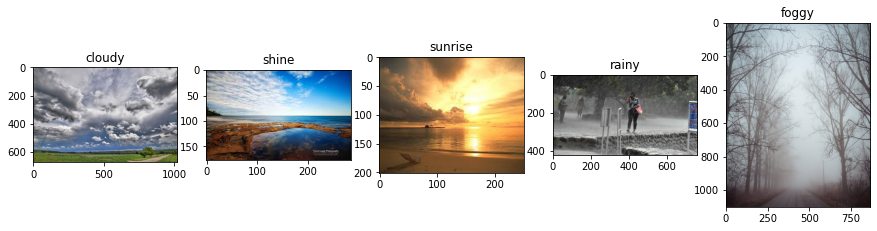

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i, folder in enumerate(image_label):
    sample_paper = random.choice(os.listdir(root_dir + folder))
    image = plt.imread(f"{root_dir}{folder}/{sample_paper}")
    ax[i].imshow(image)
    ax[i].set_title(folder)

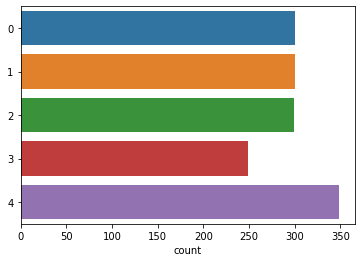

In [12]:
# 예측값의 종류별 빈도수 입니다. 250~250 개 사이에 빈도수가 분포되어 있습니다.
sns.countplot(y=y)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(150,150, 3),))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=1, padding='valid',))
model.add(MaxPooling2D(2,2))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(256, activation='relu'))    
model.add(Dense(5, activation='softmax'))

(None, 36, 36, 32)
(None, 41472)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               10617088  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [16]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics="accuracy")

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [17]:
history = model.fit(x_train, y_train_lb, epochs=5, validation_data=(x_test,y_test_lb),
                    batch_size=32,verbose=1)

Epoch 1/5
38/38 [==============================] - 10s 265ms/step - loss: 2.2397 - accuracy: 0.5731 - val_loss: 0.7548 - val_accuracy: 0.7100
Epoch 2/5
38/38 [==============================] - 10s 269ms/step - loss: 0.7300 - accuracy: 0.7260 - val_loss: 0.5954 - val_accuracy: 0.7433
Epoch 3/5
38/38 [==============================] - 10s 275ms/step - loss: 0.5587 - accuracy: 0.7861 - val_loss: 0.5487 - val_accuracy: 0.7667
Epoch 4/5
38/38 [==============================] - 9s 246ms/step - loss: 0.4296 - accuracy: 0.8296 - val_loss: 0.4546 - val_accuracy: 0.8100
Epoch 5/5
38/38 [==============================] - 10s 256ms/step - loss: 0.3966 - accuracy: 0.8488 - val_loss: 0.5231 - val_accuracy: 0.8133


In [18]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,2.239718,0.573099,0.754844,0.710000
1,0.730028,0.725982,0.595398,0.743333
2,0.558718,0.786132,0.548672,0.766667
3,0.429558,0.829574,0.454614,0.810000
4,0.396635,0.848789,0.523099,0.813333


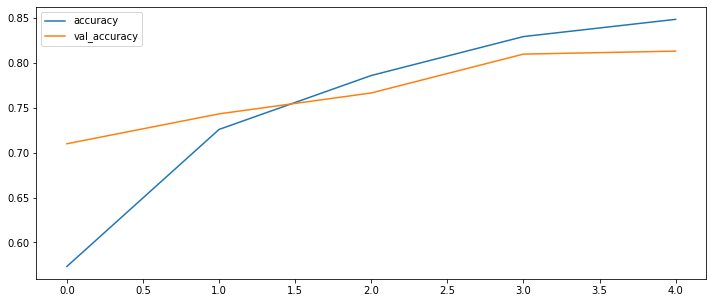

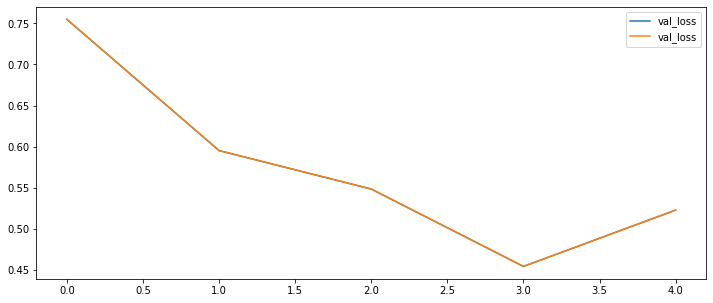

In [19]:
df_hist[["accuracy", "val_accuracy"]].plot(figsize=(12, 5))
df_hist[["val_loss", "val_loss"]].plot(figsize=(12, 5))

## 6.2 데이터 증강
* Keras 전처리 층을 사용하여 데이터 증강을 할 수 있습니다.  tf.keras.layers.experimental.preprocessing API로 접근할 수 있습니다. 동일한 이미지들을 조금씩 변형시켜가며 학습하면 Overfitting을 방지하는 데 도움이 됩니다. 하지만 이미지 변형시 정보가 왜곡되는 것에 유의해야 합니다. 

In [20]:
from tensorflow.keras.layers.experimental import preprocessing
img_size = 150

data_augmentation = Sequential([
    preprocessing.Resizing(img_size, img_size),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomContrast(1),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
])

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(150,150, 3),))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=1, padding='valid',))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))    
model.add(Dense(5, activation='softmax'))

In [22]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics="accuracy")

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [23]:
history = model.fit(x_train, y_train_lb, epochs=5, validation_data=(x_test,y_test_lb),
                    batch_size=32,verbose=1)

Epoch 1/5
38/38 [==============================] - 11s 285ms/step - loss: 2.8810 - accuracy: 0.4286 - val_loss: 1.0366 - val_accuracy: 0.5833
Epoch 2/5
38/38 [==============================] - 11s 281ms/step - loss: 1.0999 - accuracy: 0.5739 - val_loss: 1.0215 - val_accuracy: 0.5733
Epoch 3/5
38/38 [==============================] - 11s 290ms/step - loss: 0.9983 - accuracy: 0.5798 - val_loss: 0.8398 - val_accuracy: 0.6567
Epoch 4/5
38/38 [==============================] - 13s 342ms/step - loss: 0.9332 - accuracy: 0.6316 - val_loss: 0.7510 - val_accuracy: 0.7233
Epoch 5/5
38/38 [==============================] - 11s 290ms/step - loss: 0.9041 - accuracy: 0.6391 - val_loss: 0.7669 - val_accuracy: 0.7067


In [24]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,2.881007,0.428571,1.036616,0.583333
1,1.099851,0.573935,1.021456,0.573333
2,0.998280,0.579783,0.839786,0.656667
3,0.933179,0.631579,0.750952,0.723333
4,0.904092,0.639098,0.766943,0.706667


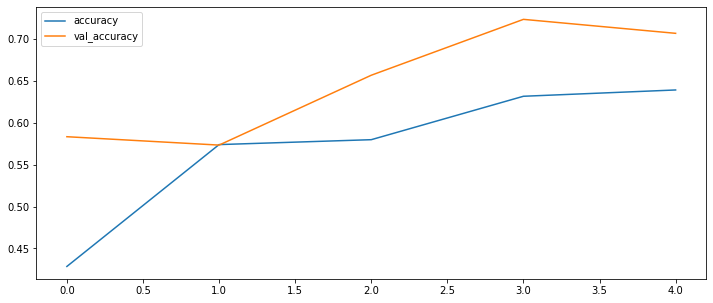

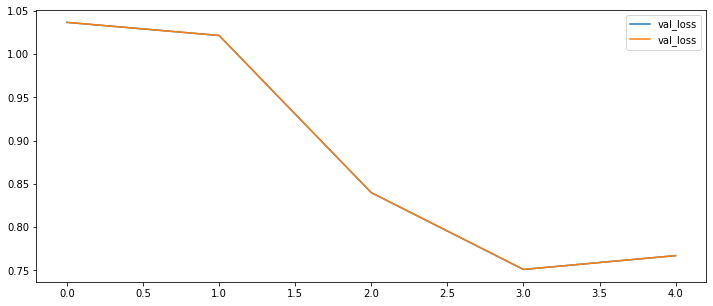

In [25]:
df_hist[["accuracy", "val_accuracy"]].plot(figsize=(12, 5))
df_hist[["val_loss", "val_loss"]].plot(figsize=(12, 5))

## 6.3 배치 정규화
* 합성곱 신경망에 배치 정규화 적용해 봅니다. 각 층에서 활성화 함수를 통과하기 전이나 후에 모델 연산을 추가합니다.

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(150,150, 3),))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=1, padding='valid',))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))    
model.add(Dense(5, activation='softmax'))

In [27]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics="accuracy")

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [30]:
history = model.fit(x_train, y_train_lb, epochs=5, validation_data=(x_test,y_test_lb),
                    batch_size=32,verbose=1)

Epoch 1/5
38/38 [==============================] - 8s 201ms/step - loss: 0.9109 - accuracy: 0.8187 - val_loss: 1.3918 - val_accuracy: 0.6800
Epoch 2/5
38/38 [==============================] - 10s 269ms/step - loss: 0.5493 - accuracy: 0.8722 - val_loss: 2.2372 - val_accuracy: 0.6033
Epoch 3/5
38/38 [==============================] - 11s 285ms/step - loss: 0.3867 - accuracy: 0.8772 - val_loss: 1.6115 - val_accuracy: 0.7033
Epoch 4/5
38/38 [==============================] - 11s 299ms/step - loss: 0.3490 - accuracy: 0.9056 - val_loss: 2.3152 - val_accuracy: 0.7067
Epoch 5/5
38/38 [==============================] - 11s 289ms/step - loss: 0.2160 - accuracy: 0.9231 - val_loss: 1.6222 - val_accuracy: 0.7567


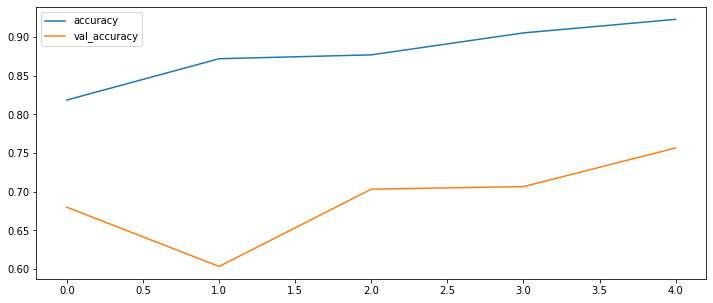

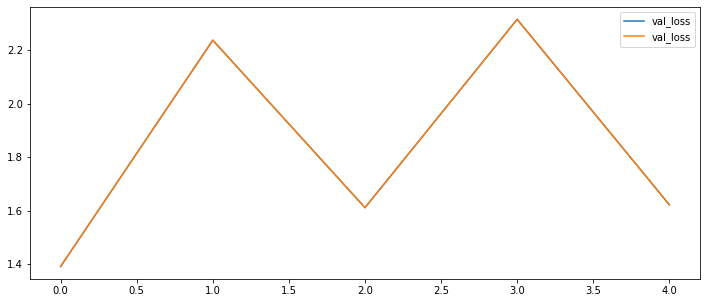

In [33]:
df_hist = pd.DataFrame(history.history)
df_hist[["accuracy", "val_accuracy"]].plot(figsize=(12, 5))
df_hist[["val_loss", "val_loss"]].plot(figsize=(12, 5))